In [8]:
import os
import pandas as pd
from copy import deepcopy
from collections import defaultdict
import geopandas as gp
from matplotlib import pyplot as plt

import numpy as np

# PAM - Geometry Sampling

This notebook shows how to sample geometrical locations from ozone/dzone regions.


In [2]:
trips = pd.read_csv('data/example_data/example_travel_diaries.csv')
attributes = pd.read_csv('data/example_data/example_attributes.csv')
attributes.set_index('pid', inplace=True)

In [4]:
trips.head(20)

,uid,pid,hid,seq,hzone,ozone,dzone,purp,mode,tst,tet,freq
0,0,census_0,census_0,0,Harrow,Harrow,Camden,work,pt,444,473,1000
1,1,census_0,census_0,1,Harrow,Camden,Harrow,work,pt,890,919,1000
2,2,census_1,census_1,0,Greenwich,Greenwich,Tower Hamlets,work,pt,507,528,1000
3,3,census_1,census_1,1,Greenwich,Tower Hamlets,Greenwich,work,pt,1065,1086,1000
4,4,census_2,census_2,0,Croydon,Croydon,Croydon,work,pt,422,425,1000
5,5,census_2,census_2,1,Croydon,Croydon,Croydon,work,pt,917,920,1000
6,6,census_3,census_3,0,Haringey,Haringey,Redbridge,work,pt,428,447,1000
7,7,census_3,census_3,1,Haringey,Redbridge,Haringey,work,pt,1007,1026,1000
8,8,census_4,census_4,0,Hounslow,Hounslow,"Westminster,City of London",work,car,483,516,1000
9,9,census_4,census_4,1,Hounslow,"Westminster,City of London",Hounslow,work,car,1017,1050,1000


### Sample Geometries
Transform trip ozone/dzone to geographically sampled points

In [9]:
from pam.samplers.spatial import GeometryRandomSampler

geom_sampler = GeometryRandomSampler(geo_df_file="data/example_data/geometry.geojson",
                                     geometry_name_column="NAME",
                                     default_region="Westminster,City of London")

geo_trips = trips.copy()
geo_trips['start_loc'] = geo_trips.apply(lambda x: geom_sampler.sample_point(x['ozone']), axis=1)
geo_trips['end_loc'] = geo_trips.apply(lambda x: geom_sampler.sample_point(x['dzone']), axis=1)


### Build Activity Plans

First we convert the travel diary data to Activity Plans:

In [11]:
from pam import read
population = read.load_travel_diary(geo_trips, attributes, include_loc=True)

Let's check out an example Activity Plan and Attributes:

Person: census_120
{'gender': 'other', 'job': 'work', 'occ': 'white', 'inc': 'low'}
0:	Activity(0 act:home, location:POINT (549435.6681744548 171044.1908635257), time:00:00:00 --> 09:47:00, duration:9:47:00)
1:	Leg(0 mode:pt, area:POINT (549435.6681744548 171044.1908635257) --> POINT (547017.2703928507 180563.651372189), time:09:47:00 --> 10:04:00, duration:0:17:00)
2:	Activity(1 act:work, location:POINT (547017.2703928507 180563.651372189), time:10:04:00 --> 17:12:00, duration:7:08:00)
3:	Leg(1 mode:pt, area:POINT (543370.212784305 177604.3069484807) --> POINT (544690.4654892718 172666.9404792268), time:17:12:00 --> 17:29:00, duration:0:17:00)
4:	Activity(2 act:home, location:POINT (544690.4654892718 172666.9404792268), time:17:29:00 --> 00:00:00, duration:6:31:00)


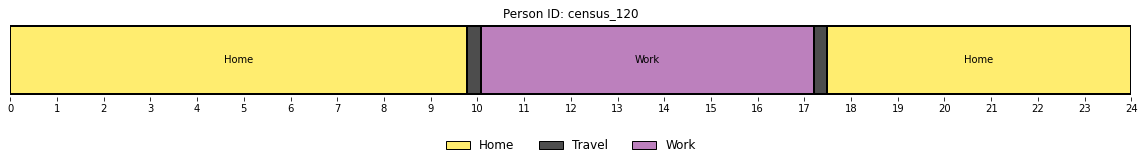

In [12]:
household = population.households['census_120']
person = household.people['census_120']
person.print()
person.plot()

In [13]:
person.attributes

{'gender': 'other', 'job': 'work', 'occ': 'white', 'inc': 'low'}

### Output Matsim XML

In [14]:
from pam.write import write_matsim_plans, write_matsim_attributes

write_matsim_plans(population, "./outputs/example_output_plans.xml")
write_matsim_attributes(population, "./outputs/example_output_attributes.xml")